# response tmax bound

This notebook shows how to bound the maximum duration of your response function. For now this is only implemented for the Gamma response function in combination with the LmfitSolver.

As an example the data is used from the basic model notebook.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

import pastas as ps

import lmfit
import numpy as np

ps.show_versions()

Pastas version: 1.11.0.dev0
Python version: 3.12.10
NumPy version: 2.2.6
Pandas version: 2.3.1
SciPy version: 1.16.1
Matplotlib version: 3.10.5
Numba version: 0.61.2


### 1. Importing time series data
See the [basic model notebook](basic_model.ipynb) for more information.

In [12]:
# Import groundwater time seriesm and squeeze to Series object
gwdata = pd.read_csv(
    "data/head_nb1.csv", parse_dates=["date"], index_col="date"
).squeeze()

# Import observed precipitation series
precip = pd.read_csv(
    "data/rain_nb1.csv", parse_dates=["date"], index_col="date"
).squeeze()

# Import observed evaporation series
evap = pd.read_csv(
    "data/evap_nb1.csv", parse_dates=["date"], index_col="date"
).squeeze()

# Calculate the recharge to the groundwater
recharge = (precip - evap).dropna()
recharge.name = "recharge"  # set name if pandas series

### 2. Create the time series model
First we create a timeseries model without a bound for the maximum duration of the response. 

In [14]:
# Create a model object by passing it the observed series
ml = ps.Model(gwdata, name="GWL")

# Add the recharge data as explanatory variable
sm = ps.StressModel(recharge, ps.Gamma(), name="recharge", settings="evap")
ml.add_stressmodel(sm)

ml.solve(report=False)
print(f'the tmax of the recharge response is {ml.get_response_tmax("recharge"):.0f} days')

the tmax of the recharge response is 784 days


### 3. Model with response tmax bound
Now we create a timeseries model with a maximum bound for the response.

In [16]:
# Create a model object by passing it the observed series
ml2 = ps.Model(gwdata, name="500d")

# Add the recharge data as explanatory variable
sm2 = ps.StressModel(recharge, ps.rfunc.Gamma_tmaxbound(500), name="recharge", settings="evap")
ml2.add_stressmodel(sm2)

ml2.solve(solver=ps.solver.LmfitSolve())
ml2.get_response_tmax('recharge')

Fit report 500d                   Fit Statistics
nfev    64                     EVP         89.71
nobs    644                    R2           0.90
noise   False                  RMSE         0.14
tmin    1985-11-14 00:00:00    AICc     -2544.23
tmax    2015-06-28 00:00:00    BIC      -2526.42
freq    D                      Obj         12.24
warmup  3650 days 00:00:00     ___              
solver  LmfitSolve             Interp.        No

Parameters (4 optimized)
                  optimal     initial   vary
recharge_A     522.207011  215.674528   True
recharge_n       1.555224    1.000000   True
recharge_tmax  500.000000   69.077553   True
recharge_a      60.536122   10.000000  False
constant_d      27.656983   27.900078   True

Warnings! (1)
Parameter 'recharge_tmax' on upper bound: 5.00e+02


np.float64(499.9999999808999)

In [18]:
# Create a model object by passing it the observed series
ml3 = ps.Model(gwdata, name="200d")

# Add the recharge data as explanatory variable
sm3 = ps.StressModel(recharge, ps.rfunc.Gamma_tmaxbound(200), name="recharge", settings="evap")
ml3.add_stressmodel(sm3)

ml3.solve(solver=ps.solver.LmfitSolve())
ml3.get_response_tmax('recharge')

Fit report 200d                   Fit Statistics
nfev    211                    EVP         74.06
nobs    644                    R2           0.74
noise   False                  RMSE         0.22
tmin    1985-11-14 00:00:00    AICc     -1948.48
tmax    2015-06-28 00:00:00    BIC      -1930.67
freq    D                      Obj         30.86
warmup  3650 days 00:00:00     ___              
solver  LmfitSolve             Interp.        No

Parameters (4 optimized)
                  optimal     initial   vary
recharge_A     312.036113  215.674528   True
recharge_n       5.445975    1.000000   True
recharge_tmax  200.000000   69.077553   True
recharge_a      12.868106   10.000000  False
constant_d      27.754273   27.900078   True

Warnings! (1)
Parameter 'recharge_tmax' on upper bound: 2.00e+02


np.float64(199.99999999962355)

### 4. Compare models

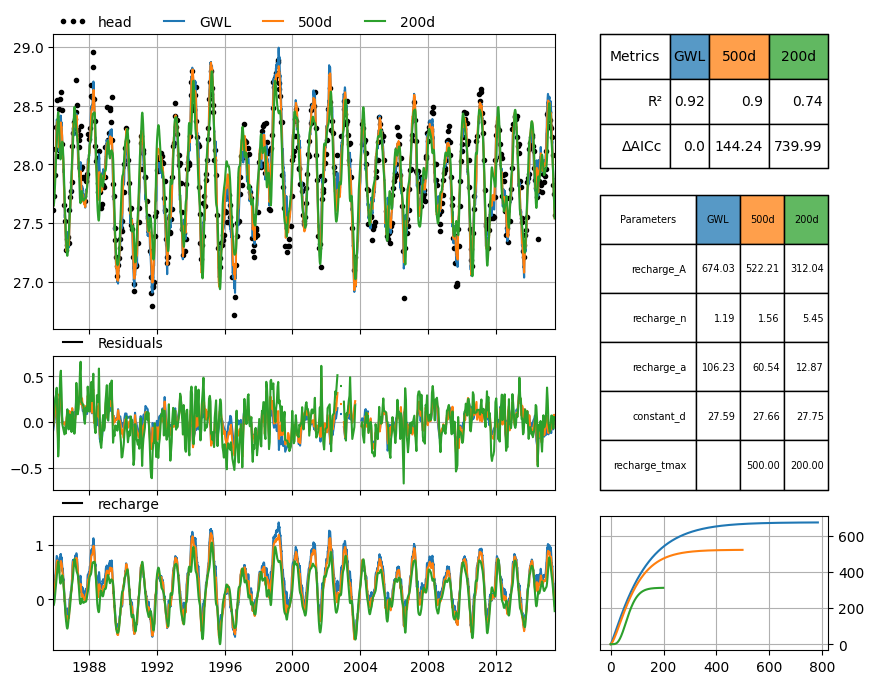

In [19]:
mc = ps.CompareModels(models=[ml, ml2, ml3])
mc.plot()